In [21]:
import numpy as np

# Embed fonts into PDF/PS files
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors

import scipy.integrate

# For plotting energy surface
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [3]:
matplotlib.rcParams.update({'font.size': 8, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial']})

# Simulation for Figure 3

In [10]:
input_ = 0.32*np.array([1,1])

In [29]:
tau_m = 0.1 # s (= 100 ms)


W = np.array([[0, 1], [2-np.sqrt(3), np.sqrt(3)-1]])
M = 1/tau_m*(np.eye(2) - W) # overall dynamics matrix

def simpleIntegrator(t,y, learn):
    dydt = -1/tau_m*(np.dot(np.eye(2) - W, y))+ 1/tau_m*input_*learn
    return dydt

In [30]:
# Total time between pulses
T = 1.5 # s
pulse_len = 0.1 # s

pulses = 3

dt = 1e-3 # ms


t_pulse = np.arange(0, int(pulse_len/dt), 1)*dt
t_post = np.arange(0, int(np.ceil((T-pulse_len)/dt)), 1)*dt
t = np.arange(0, int(T/dt),1)*dt
y_sol = np.zeros((2, len(t), pulses))

inputs = np.zeros((len(t),pulses))

y_0 = np.array([0, 0])
y = np.copy(y_0)


# learn = False
for d in range(pulses):
    sol_pulse = scipy.integrate.solve_ivp(lambda t,y: simpleIntegrator(t,y, True), [0, pulse_len], y, 
                                          jac=lambda t,y: M, dense_output=True)
    inputs[:len(t_pulse), d] = 1
    sol_post = scipy.integrate.solve_ivp(lambda t,y: simpleIntegrator(t,y, False), [0,T-pulse_len],sol_pulse.sol(pulse_len),
                                          jac=lambda t,y: M, dense_output=True)
    y_sol[:,:,d] = np.hstack((sol_pulse.sol(t_pulse), sol_post.sol(t_post)))
    y = sol_post.sol(T-pulse_len)

/Users/jbhasin/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:40: UserWarning: The following arguments have no effect for a chosen solver: `jac`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


In [31]:
y_total = np.vstack(y_sol.T).T
t_total = np.concatenate([t + T*d for d in range(pulses) ])

In [32]:
inputs_total = np.concatenate(inputs.T)

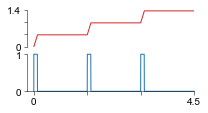

In [33]:
plt.figure(figsize=(3,1.5))

ax=plt.subplot(2,1,1)

plt.plot(t_total,1/np.sqrt(2)*np.dot(np.array([1,1]), y_total),  lw=1,c='C3')

ax.xaxis.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks(np.linspace(0,1.4, 4))
ax.set_yticklabels([0,'','', 1.4])

plt.xlim(-0.2, 4.5)
plt.ylim([0, 1.4])

ax = plt.subplot(2,1,2)

plt.plot(np.concatenate((np.array([0]), t_total)), np.concatenate((np.array([0]), inputs_total)), lw=1, c='C0', clip_on=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim([0,1])
ax.set_yticks([0,1])
ax.set_yticklabels([0,1])
plt.xlim(-0.2, 4.5)
ax.set_xticks([0,1.5,3.0,4.5])
ax.set_xticklabels([0, '','',4.5]);

# Plot Lyapunov function

In [34]:
r1_width = 2*np.sqrt(2)/3*0.83
r2_width = np.sqrt(2)

r1, r2 = np.meshgrid(np.linspace(0.5-r1_width/2,0.5+r1_width/2, 200), np.linspace(0.5-r2_width/2, 0.5+r2_width/2, 200))

# Rotate coordinate grid to align with integrating mode
rot = np.pi/4
center = [0.5,0.5]

r1_r = np.cos(rot)*(r1-center[0]) + np.sin(rot)*(r2-center[1]) + center[0]
r2_r = -np.sin(rot)*(r1-center[0]) + np.cos(rot)*(r2-center[1]) + center[1]

In [35]:
dr1 = M[0,0]*r1_r + M[0,1]*r2_r
dr2 = M[1,0]*r1_r + M[1,1]*r2_r

In [36]:
T = 0.5
dt_lyapunov = 5e-3
t = np.arange(0, T//dt_lyapunov, 1)*dt_lyapunov

rot_e = 60 * 180/np.pi # second e-vector at 60 deg angle from integrating mode

eig1 = np.array([1,1])/np.sqrt(2)
eig2 = np.dot(np.array([[np.cos(rot_e), np.sin(rot_e)], [-np.sin(rot_e), np.cos(rot_e)]]), eig1)

e2len = (r1_width/2)/np.sin(rot_e)

# Trajectories on bottom of phase plot
trajectories_0 = np.array([[1/3+eig2[0]*e2len, 1/3+eig2[1]*e2len],
                           [1/3-eig2[0]*e2len, 1/3-eig2[1]*e2len],
                           [2/3+eig2[0]*e2len, 2/3+eig2[1]*e2len],
                           [2/3-eig2[0]*e2len, 2/3-eig2[1]*e2len],
                          ])

n_ = trajectories_0.shape[0]

trajectories = np.zeros((n_, 2, len(t)))

for i in range(n_):
    sol = scipy.integrate.solve_ivp(lambda t,y: simpleIntegrator(t,y, False), [0,T],trajectories_0[i,:],
                                          jac=lambda t,y: M,dense_output=True)
    sol_ = sol.sol(t)
    trajectories[i,0,:] = sol_[0,:]
    trajectories[i,1,:] = sol_[1,:]

/Users/jbhasin/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:40: UserWarning: The following arguments have no effect for a chosen solver: `jac`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


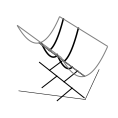

In [38]:
fig = plt.figure(figsize=(1.5, 1.5))

z_offset = -30
ax = fig.gca(projection='3d')

# Plot attractor
plt.plot([0,1],[0., 1],[z_offset, ]*2,'k',lw=1)

# Plot Lyapunov function surface
ax.plot_wireframe(r1_r, r2_r, dr1**2+dr2**2,color=(0.5,0.5,0.5),cstride=100,rstride=200,
                       linewidth=1)
plt.plot([0,1],[0, 1],[0, ]*2,'k',lw=1)

# Plot trajectories
for i in range(n_):
    r1_ = trajectories[i,0,:]
    r2_ = trajectories[i,1,:]
    dr1_ = M[0,0]*r1_ + M[0,1]*r2_
    dr2_ = M[1,0]*r1_ + M[1,1]*r2_
    ax.plot(r1_, r2_, z_offset*np.ones(len(t)), color='k', lw=1)
    ax.plot(r1_,r2_, dr1_**2+dr2_**2, color='k')

ax.grid(b=None)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_zticks([]);
ax.set_yticks([]);
ax.set_xticks([]);
ax.w_zaxis.line.set_lw(0.)
zlims = ax.get_zlim();
ax.set_zlim([z_offset, zlims[1]])
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])

ax.view_init(25, -135-30)

plt.subplots_adjust(left=0.02, right=0.98, bottom=0.02, top=0.98);